In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Opening the csv files and looking how the data is organized

In [30]:
wind_speed = pd.read_csv('PSR Wind Speed.csv')
wind_speed.head()

,Hour,Speed_at_2m,Speed_at_10m,Speed_at_50m,Speed_at_100m
0,0,3.255744,4.505530,6.235073,7.171469
1,1,3.162930,4.380023,6.065452,6.978388
2,2,2.912983,4.094024,5.753906,6.662267
3,3,2.464452,3.551877,5.119121,5.991837
4,4,2.136369,3.128332,4.580886,5.398652


In [31]:
turbine_power = pd.read_csv('PSR Turbine Power Curves.csv')
turbine_power.head()

,speed,Nordex_N131_3000
0,0.00,0.0
1,0.01,0.0
2,0.02,0.0
3,0.03,0.0
4,0.04,0.0


## First challenge

The power law was choosen for extapolating the speeds, The power law is better used under 100 metres, and the log law up to 1000, but as neither surface roughness nor atmospheric stability was available, the power law was chosen.

The first step was finding the alphas for the power law.

In [32]:
def find_alphas(speeds):
    measure_heights = [2, 10, 50, 100]
    alphas = [[(np.log(speeds[i]/speeds[k]))/(np.log(measure_heights[i]/measure_heights[k])) for i in range(k + 1, 4)] for k in range(3)]
    return (alphas)

alphas_list = find_alphas(((wind_speed.iloc[0]).values.tolist())[1:])
for line in alphas_list:
    print(line, end = " ")

[0.20186220107970682, 0.20186220111372735, 0.20186220110893752] [0.2018622011477478, 0.2018622011293688] [0.2018622010866941] 

As it was found that the difference between the alphas calculated with different height tuples is really low, the speeds at 10m and 2m were chosen to calculate it.
After choosing the alpha, the speed at the hub height was calculated and it was plotted.

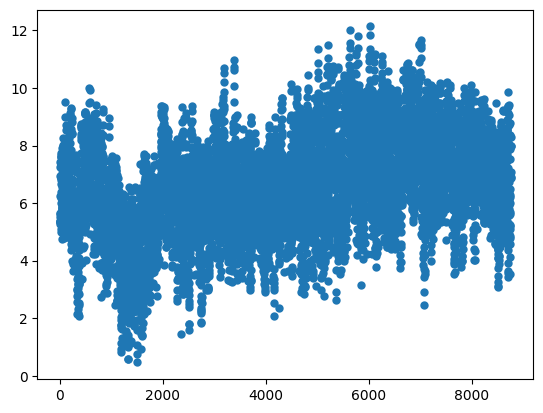

In [33]:
def find_alpha(speeds):
    return ((np.log(speeds[1]/speeds[0]))/(np.log(5)))

def find_speed(speeds):
    alpha = find_alpha(speeds)
    return (speeds[0]*np.power(60, alpha))

def extrapolate_speeds(cf):
    speeds = list()
    for line in range(len(wind_speed)):
        speed = find_speed([corrected_speed*cf for corrected_speed in ((wind_speed.iloc[line]).values.tolist())[1:3]])
        speeds.append(speed)
    return speeds

speeds = extrapolate_speeds(1)

plt.scatter(range(len(wind_speed)), speeds, linewidths=0.01)
plt.show()

Then it was ploted a running mean with a period of one day for better clarity.

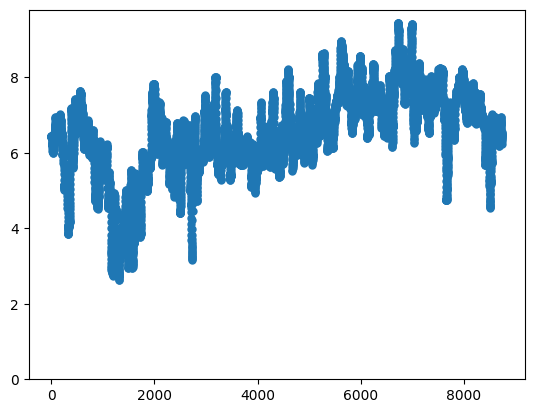

In [34]:
running_mean = np.convolve(speeds, np.ones(24)/24, mode='valid')
plt.scatter(range(len(running_mean)), running_mean, linewidths=0.01)
plt.ylim(bottom = 0)
plt.show()

It was not enough so a running mean with a period of one month was chosen.

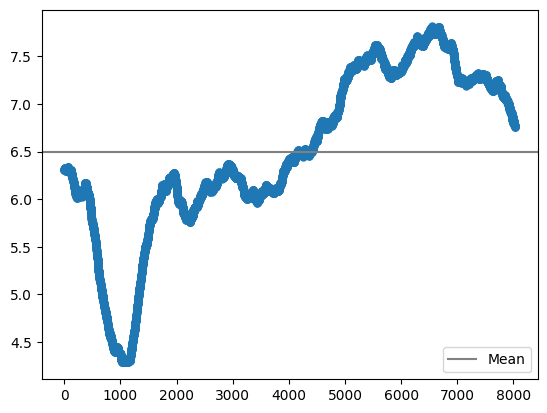

In [35]:
running_mean_speeds = np.convolve(speeds, np.ones(730)/730, mode='valid')
plt.scatter(range(len(running_mean_speeds)), running_mean_speeds, linewidths=0.01)
plt.axhline(y=np.nanmean(speeds), color = 'grey', label = 'Mean')
plt.legend(loc = 'lower right')
plt.show()

## Second challenge
The speed on the turbine power csv is divided in 0.01 increments, with that information, it was simple as multiplicating the speed found by 100 and then finding corresponding power.

In [36]:
power_series = list()
for value in speeds:
    pos = int ((value)*100)
    power_series.append(turbine_power['Nordex_N131_3000'].iloc[pos])

print(power_series[:10])

[0.519376265, 0.479131584, 0.417709765, 0.302615581, 0.218220284, 0.188241841, 0.183667168, 0.203532243, 0.220723846, 0.176921589]


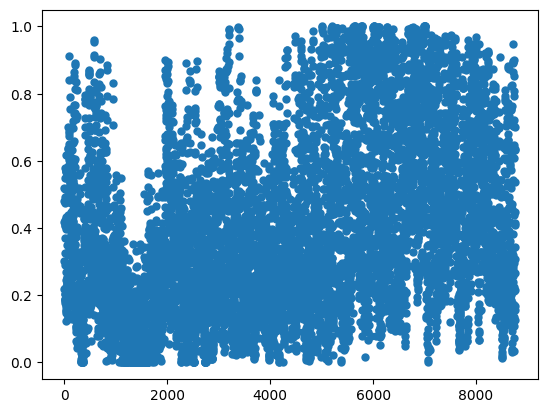

In [37]:
plt.scatter(range(len(power_series)), power_series, linewidths=0.01)
plt.show()

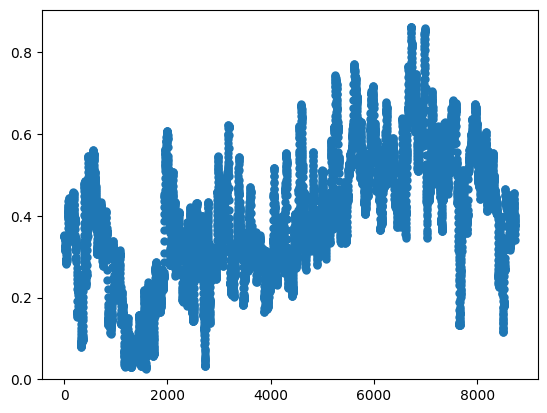

In [38]:
running_mean = np.convolve(power_series, np.ones(24)/24, mode='valid')
plt.scatter(range(len(running_mean)), running_mean, linewidths=0.01)
plt.ylim(bottom = 0)
plt.show()

As with the speed series, a running mean with a period of one month was chosen for better clarity.

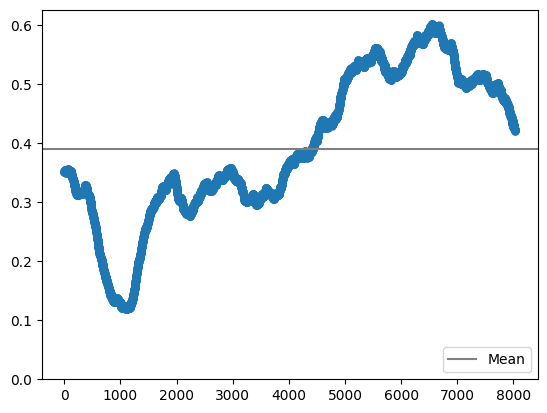

In [39]:
running_mean = np.convolve(power_series, np.ones(730)/730, mode='valid')
plt.scatter(range(len(running_mean)), running_mean, linewidths=0.01)
plt.axhline(y=np.nanmean(power_series), color = 'grey', label = 'Mean')
plt.ylim(bottom = 0)
plt.legend(loc = 'lower right')
plt.show()

## Third challenge
The data for capacity factor by month in the northeast was found in the following article: [Input data for power and energy models:
methodologies and assumptions](https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-707/NT%20EPE-DEE-011-2021-R2_Input%20data%20for%20models.pdf)

As for the bias correction factor, it was found in the following article: [Assessing the Global Wind Atlas and local measurements for bias correction of wind power generation simulated from MERRA-2 in Brazil](https://www.sciencedirect.com/science/article/abs/pii/S0360544219319073?via%3Dihub)

>On these levels, mean capacities from ONS and The Wind Power were compared, and
>capacity bias correction factor for Brazil, the North-East and the South were determined for the whole
>period. These are all below 1 (Brazil 0.93, North-East 0.92, South 0.99), meaning that the capacities given by The Wind
>Power are decreased to the level of ONS capacities.

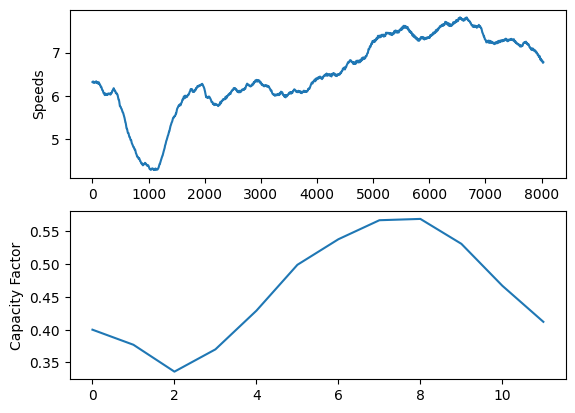

In [40]:
capacity_factor = [0.4, 0.377, 0.336, 0.37, 0.429, 0.499, 0.538, 0.567, 0.569, 0.531, 0.467, 0.412]

fig, ax = plt.subplots(2, 1)
ax[0].plot(range(len(running_mean_speeds)), running_mean_speeds)
ax[0].set_ylabel("Speeds")

ax[1].plot(range(12), capacity_factor)
ax[1].set_ylabel('Capacity Factor')

fig.show()

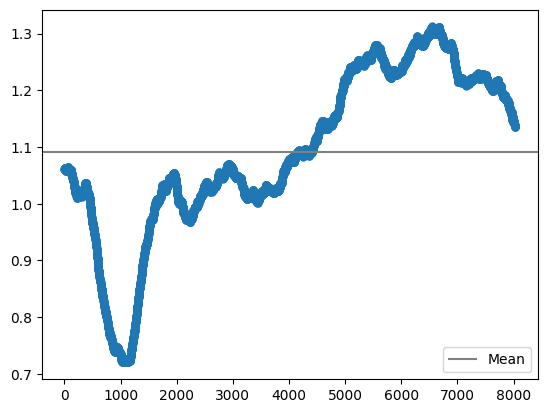

In [41]:
cf = 0.92
c_alpha = 0.6*cf + 0.2
c_beta = np.zeros(len(speeds))

for index, value in enumerate(speeds):
    c_beta[index] = (0.92-c_alpha)*value

running_mean = np.convolve(c_beta, np.ones(730)/730, mode='valid')
plt.scatter(range(len(running_mean)), running_mean, linewidths=0.01)
plt.axhline(y=np.nanmean(c_beta), color = 'grey', label = 'Mean')
plt.legend(loc = 'lower right')
plt.show()

The correction factor is in relation the MERRA 2 reanalyses database, however, as the heights choosen to find the power law alpha were 10m and 2m, there was no need to change the function made in the first challenge.

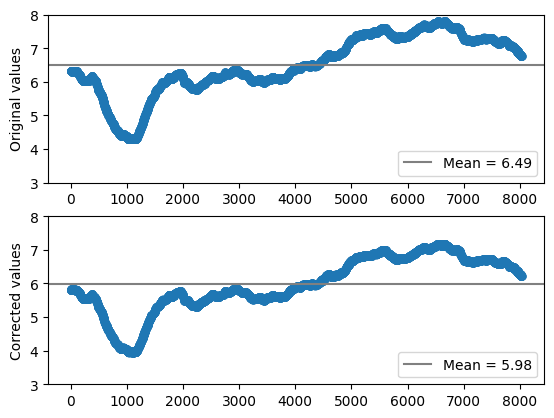

In [42]:
fig, ax = plt.subplots(2, 1)

c_speeds = extrapolate_speeds(cf)
running_mean_corrected = np.convolve(c_speeds, np.ones(730)/730, mode='valid')
y = np.nanmean(running_mean_corrected)
ax[1].scatter(range(len(running_mean_corrected)), running_mean_corrected, linewidths=0.01)
ax[1].axhline(y, color = 'grey', label = 'Mean = %0.2f'%(y))
ax[1].legend(loc = 'lower right')
ax[1].set_ylabel("Corrected values")

y = np.nanmean(speeds)
ax[0].scatter(range(len(running_mean_speeds)), running_mean_speeds, linewidths=0.01)
ax[0].axhline(y, color = 'grey', label = 'Mean = %0.2f'%(y))
ax[0].legend(loc = 'lower right')
ax[0].set_ylabel('Original values')

plt.setp(ax, ylim=(3,8))
plt.show()